In [1]:
import numpy as np
from numpy.random import randint
import networkx as nx
from collections import defaultdict
import time
from algo import radix_argsort, quick_argsort, bucket_argsort

%matplotlib notebook
import matplotlib.pyplot as plt
%pylab inline
import sys
sys.setrecursionlimit(10000)

Populating the interactive namespace from numpy and matplotlib


## Генераторы графов

In [2]:
# функция возвращает случайный простой граф в моделе Gnp 
# вероятность ребра p = 2*m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnp_graph(n, m, seed=42):
  edge_p = 2*m/(n*(n-1))
  g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed)
  
  return nx.convert.to_dict_of_lists(g)

In [3]:
# функция возвращает случайный ориентированный граф в моделе Gnp 
# вероятность ребра p = m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_Gnp_digraph(n, m, seed=42):
  edge_p = m/(n*(n-1))
  g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed,True)
  
  return nx.convert.to_dict_of_lists(g)

In [4]:
# функция возвращает случайный простой граф в моделе Gnm 
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnm_graph(n, m, seed=42):
  g = nx.random_graphs.gnm_random_graph(n,m,seed)

  return nx.convert.to_dict_of_lists(g)

In [5]:
# функция возвращает случайный ориентированный граф в моделе Gnm
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_Gnm_digraph(n, m, seed=42):
  g = nx.random_graphs.gnm_random_graph(n,m,seed,True)

  return nx.convert.to_dict_of_lists(g)

In [6]:
# функция возвращает связный ориентированный Ейлеров граф
# в графе n вершин, k - параметр, от которого зависти генерация
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_Euler_digraph(n, k=8):
  in_degs, out_degs = [k]*n, [k]*n 
  G = nx.generators.directed_havel_hakimi_graph(in_degs, out_degs)
  WCCs = list(nx.algorithms.components.weakly_connected_components(G))
  if len(WCCs) > 1:
    connecting_nodes = []
    for WCC in WCCs:
      some_vertex_of_WCC = next(iter(WCC))
      connecting_nodes.append(some_vertex_of_WCC)
    for i in range(1, len(connecting_nodes)):
      G.add_edge(connecting_nodes[i-1],connecting_nodes[i])
      G.add_edge(connecting_nodes[i],connecting_nodes[i-1])
    
  return nx.convert.to_dict_of_lists(G)

In [7]:
# утилитарная функция, переводящая таплы вида (1, 0, 0, 1)
# в числа, интерпетируя эту запись как число в двоичной записи
# эта функция нужна для следующей функции
def get_index_from_binary(tup):
  n = len(tup)
  mult = 1
  res = 0
  for i in range(n):
    res += tup[i]*mult
    mult *= 2
  return res

# функция возвращает связный ориентированный регулярный Ейлеров граф
# входные и выходные степени всех вершин совпадают и равны half_dim
# число вершин равно 4**half_dim
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_hypercube_digraph(half_dim):
  G = nx.generators.hypercube_graph(half_dim*2)
  directed_G = nx.DiGraph()
  Euler_circuit_G = nx.algorithms.eulerian_circuit(G)
  for (u,v) in Euler_circuit_G:
    directed_G.add_edge(get_index_from_binary(u), get_index_from_binary(v))
  return nx.convert.to_dict_of_lists(directed_G)

# Алгоритмы для поиска мостов

In [8]:
def compute_bridges_determ(adj_list):
  res = []
  colors = np.zeros((len(adj_list)))
  ent = np.zeros((len(adj_list)))
  m = np.full((len(adj_list)), np.inf)
  timer = 0
  def dfs(v, parent):
    nonlocal timer
    colors[v] = 1
    ent[v] = timer
    timer += 1

    for u in adj_list[v]:
      if colors[u] == 0:
        dfs(u, v)
        m[v] = min(m[v], m[u])
        if m[u] > ent[v]:
          res.append((min([v, u]), max([v, u])))
      elif colors[u] == 1 and u != parent:
        m[v] = min(m[v], ent[u])
    
    colors[v] = 2

  for i in range(0, len(adj_list)):
    if not colors[i] == 2:
      dfs(i, -1)

  return set(res)

In [9]:
# рандомизированный алгоритм для поиска мостов
# на вход поступает граф представленный списком смежности
# саписок представлен как словарь(хеш-таблица) списков 
# выход представляет собой список ребер, являющихся мостами с большой вероятностью
def compute_bridges_rand(adj_list):
  colors = np.zeros((len(adj_list)))
  labels = {}
  def dfs(v, parent):
    colors[v] = 1
    v_label = np.uint64(0)
    for u in adj_list[v]:
      e = (min([u,v]), max([u,v]))
      if colors[u] == 0:
        labels[e] = dfs(u, v)
        v_label = v_label ^ labels[e]
      elif colors[u] == 1 and u != parent:
        labels[e] = randint(0, 0xFFFFFFFFFFFFFFFF, dtype=np.uint64)
        v_label = v_label ^labels[e]

    colors[v] = 2
    return v_label

  for i in range(0, len(adj_list)):
    if not colors[i] == 2:
      dfs(i, -1)

  return set([v for v, l in labels.items() if l == 0])

In [10]:
# рандомизированный алгоритм для поиска 2-мостов
#
# на вход поступает граф представленный списком смежности и алгоритм сортировки для меток на ребрах
# саписок представлен как словарь(хеш-таблица) списков 
#
# выходом алгоритма является список списков ребер
# в каждом списке любая пара ребер должна с высокой вероятностью образовывать 2-мост
# например, если выходом является спискок [[e1, e2, e3],[e4, e5]]
# то с высокой вероятностью 2-мостами будут пары ребер: (e1,e2), (e1,e3), (e2,e3), (e4,e5)
# ребра здесь это пары вершин типа e1 = (1,2)
def compute_2bridges_rand(adj_list, sort_fun):
  colors = np.zeros((len(adj_list)))
  labels = {}
  def dfs(v, parent):
    colors[v] = 1
    v_label = np.uint64(0)
    for u in adj_list[v]:
      e = (min([u,v]), max([u,v]))
      if colors[u] == 0:
        labels[e] = dfs(u, v)
        v_label = v_label ^ labels[e]
      elif colors[u] == 1 and u != parent:
        labels[e] = randint(0, 0xFFFFFFFFFFFFFFFF, dtype=np.uint64)
        v_label = v_label ^labels[e]

    colors[v] = 2
    return v_label

  for i in range(0, len(adj_list)):
    if not colors[i] == 2:
      dfs(i, -1)

  edges = list(labels.keys())
  labels = list(labels.values())

  if len(labels) == 0:
    return []

  indices = sort_fun(np.array(labels))

  res = [[edges[indices[0]]]]

  for prev, cur in zip(indices[:-1], indices[1:]):
    if labels[prev] == labels[cur]:
      res[-1].append(edges[cur])
    else:
      res.append([edges[cur]])

  return [l for l in res if len(l) > 1]

# Эйлеровы циклы

In [11]:
# функция вычисляющая эйлеров обход для данного ориентированного графа G 
# цикл кодируется списком ребер, например:
# (1,2), (2,4), (4, 7), (7,1)
#

# stack overflow
def compute_Euler_circuit_digraph(adj_list):
  res = []
  colors = {}
  for v1 in adj_list.keys():
    for v2 in adj_list[v1]:
      colors[(v1, v2)] = 0
  
  def dfs(e):
    colors[e] = 1
    _, v = e
    for u in adj_list[v]:
      e2 = (v, u)
      if colors[e2] == 0:
        dfs(e2)

    colors[e] = 2
    res.append(e)

# not finish
def compute_Euler_circuit_digraph_with_stack(adj_list):
  res = []
  
  def dfs(edge):
    visited = set()
    stack = [edge]
    while len(stack) > 0:
      e = stack[-1]
      visited.add(e)
      _, v = e
      found_not_visited = False
      for u in adj_list[v]:
        e2 = (v, u)
        if not e2 in visited:
          stack.append(e2)
          found_not_visited = True
      if not found_not_visited:
        res.append(e)
        stack.pop()

  dfs((0, adj_list[0][0]))

  return res

# Арифметика в конечных кольцах и полях

In [12]:
def gcdExtended(a, b):
  if a == 0:
    return b, 0, 1
  else:
    b_div_a = b // a
    b_mod_a = b % a
    gcd, x, y = gcdExtended(b_mod_a, a)
    y = y - b_div_a * x
    return gcd, y, x

def invert_in_Zp_Euclead(p, x):
  gcd, a, b = gcdExtended(x, p)
  if gcd == 1:
    return a % p
  else:
    return 0

In [13]:
invert_in_Zp_Euclead(7,6)

6

In [14]:
def fast_pow(a, n):
    if n == 0:
        return 1
    if a == 0:
        return 0
    p = fast_pow(a, n // 2)
    p *= p
    if n % 2:
        p *= a
    return p

def invert_in_Zp_Ferma(p, x):
    gcd, _, _ = gcdExtended(x, p)
    if gcd == 1:
        return fast_pow(x, p - 2) % p
    else:
        return 0

In [15]:
invert_in_Zp_Ferma(7, 6)

6

# Стресс тесты

In [16]:
def stress_test_bridges_determ(n, m, iterations_num=1000):
  for i in range(iterations_num):
    G = get_random_simple_Gnp_graph(n, m, i)
    briges_test = compute_bridges_determ(G)
    bridges_true = set(nx.algorithms.bridges(nx.Graph(G)))
    diff = list(bridges_true.symmetric_difference(briges_test))
    if len(diff) > 0:
      raise Exception(f"Неверное решение в детерминированном алгоритме поиска мостов, n: {n}, m: {m}, seed: {i}")
  print(f"Стресс тест для детерминированного поиска мостов пройден!, n: {n}, m: {m}, iterations_num: {iterations_num}")
    

In [17]:
def stress_test_bridges_rand(n, m, iterations_num=1000):
  exp_err = m * (1/ (2**64))
  for i in range(iterations_num):
    G = get_random_simple_Gnp_graph(n, m, i)
    briges_test = compute_bridges_determ(G)
    bridges_true = set(nx.algorithms.bridges(nx.Graph(G)))
    diff = list(bridges_true.symmetric_difference(briges_test))
    if len(diff) > exp_err:
      raise Exception(f"Число ошибок в рандомизированном алгоритме поиска мостов превышено, n: {n}, m: {m}, errors_num: {len(diff)}, seed: {i}")
  print(f"Стресс тест для рандомизированного поиска мостов пройден!, n: {n}, m: {m}, iterations_num: {iterations_num}")
    

In [18]:
def stress_test_finite_fields(p = 2**61-1, iterations_num = 100000):
  for i in range(iterations_num):
    x = numpy.random.randint(1, p)
    inverse_Euclead_x = invert_in_Zp_Euclead(p,x)
    inverse_Ferma_x = invert_in_Zp_Ferma(p,x)
    if( np.gcd(p,x) == 1 ):
      if (x * inverse_Euclead_x - 1) % p != 0:
        raise Exception(f"Неправильное инвертирование алгоритмом Евклида, p: {p}, x: {x}")
      if (x * inverse_Ferma_x - 1) % p != 0:
        raise Exception(f"Неправильное инвертирование алгоритмом быстрого возведения в степень, p: {p}, x: {x}")
    else :
      if inverse_Euclead_x != 0:
        raise Exception(f"Неправильное инвертирование алгоритмом Евклида, p: {p}, x: {x}")
      if inverse_Ferma_x != 0:
        raise Exception(f"Неправильное инвертирование алгоритмом быстрого возведения в степень, p: {p}, x: {x}")  
  print(f"Стресс тест для арифметики в конечных полях пройден!, p: {p}, iterations_num: {iterations_num}")

In [19]:
def stress_test_2bridges_rand(n, m, sort, iterations_num=1000):
  exp_err = (m*(m-1)/2) * (1/ (2**64))
  for iteration in range(iterations_num):
    err_num = 0
    G = nx.Graph(get_random_simple_Gnp_graph(n, m, iteration))
    bridges_test = compute_2bridges_rand(G,sort)
    for edge_group in bridges_test:
      for e1 in range(len(edge_group)):
        for e2 in range(e1+1,len(edge_group)):
          G_with_deleted_2bridge = G.copy()
          G_with_deleted_2bridge.remove_edge(*edge_group[e1])
          G_with_deleted_2bridge.remove_edge(*edge_group[e2])
          if nx.connected.number_connected_components(G) == nx.connected.number_connected_components(G_with_deleted_2bridge):
            ++err_num
    if err_num > exp_err:
      raise Exception(f"Число ошибок в рандомизированном алгоритме поиска мостов превышено, n: {n}, m: {m}, errors_num: {err_num}, sort: {sort}, seed: {iteration}")
  print(f"Стресс тест для рандомизированного поиска мостов пройден!, n: {n}, m: {m}, , sort: {sort}, iterations_num: {iterations_num}")

In [20]:
def test_Euler_circuit(G, test_circuit):
  edges_dict = {}
  m = 0
  for (v,neib) in G.items():
    for u in neib:
      edges_dict[(v,u)] = False
      m += 1

  l = len(test_circuit)
  if m != l:
    return False

  for i in range(1,m):
    if test_circuit[i-1][1] != test_circuit[i][0]:
      return False
  if test_circuit[l-1][1] != test_circuit[0][0]:
    return False

  for e in test_circuit:
    if edges_dict.get(e, True) == True:
      return False
    else:
      edges_dict[e] = True
    
  return True

# max_n должно быть строго больше чем 10
def stress_test_Euler_circuit_digraph(max_n, iterations_num=1000):
  for iteration in range(iterations_num):
    n = np.random.randint(10, max_n)
    k = np.floor(n/4)
    G = get_Euler_digraph(n,k)
    test_circuit = compute_Euler_circuit_digraph(G)
    if not test_Euler_circuit(G, test_circuit):
      raise Exception(f"Неправильный Эйлеров обход, функция генерации: get_Euler_digraph, n: {n}, k: {k}")
  print(f"Стресс тест для ориентированных Эйлеровых циклов пройден, max_n: {max_n}, iterations_num: {iterations_num}")

In [21]:
stress_test_bridges_determ(100,30,100)
stress_test_bridges_rand(100,30,100)
stress_test_finite_fields(2347, 1000)
stress_test_2bridges_rand(100,30,radix_argsort,10)
stress_test_2bridges_rand(100,30,bucket_argsort,10)
stress_test_2bridges_rand(100,30,quick_argsort,10)
# stress_test_Euler_circuit_digraph(1000, 20)

Стресс тест для детерминированного поиска мостов пройден!, n: 100, m: 30, iterations_num: 100
Стресс тест для рандомизированного поиска мостов пройден!, n: 100, m: 30, iterations_num: 100
Стресс тест для арифметики в конечных полях пройден!, p: 2347, iterations_num: 1000
Стресс тест для рандомизированного поиска мостов пройден!, n: 100, m: 30, , sort: <function radix_argsort at 0x7efd0eef8940>, iterations_num: 10
Стресс тест для рандомизированного поиска мостов пройден!, n: 100, m: 30, , sort: <function bucket_argsort at 0x7efd0eef89d0>, iterations_num: 10
Стресс тест для рандомизированного поиска мостов пройден!, n: 100, m: 30, , sort: <function quick_argsort at 0x7efd0eef8a60>, iterations_num: 10


# Юнит тесты

In [22]:
def finite_fields_unit_tests():
  assert(invert_in_Zp_Euclead(6,4) == 0)
  assert(invert_in_Zp_Ferma(6,4) == 0)

  assert(invert_in_Zp_Euclead(6,2) == 0)
  assert(invert_in_Zp_Ferma(6,2) == 0)

  assert(invert_in_Zp_Euclead(2347,0) == 0)
  assert(invert_in_Zp_Ferma(2347,0) == 0)

  assert(invert_in_Zp_Euclead(7,6) == 6)
  assert(invert_in_Zp_Ferma(7,6) == 6)

  assert(invert_in_Zp_Euclead(2347,2346) == 2346)
  assert(invert_in_Zp_Ferma(2347,2346) == 2346)

  assert(invert_in_Zp_Euclead(1,0) == 0)
  assert(invert_in_Zp_Ferma(1,0) == 0)

  assert(invert_in_Zp_Euclead(2,0) == 0)
  assert(invert_in_Zp_Ferma(2,0) == 0)

  assert(invert_in_Zp_Euclead(2,1) == 1)
  assert(invert_in_Zp_Ferma(2,1) == 1)

In [23]:
def bridges_unit_test(G):
  test_bridges_determ = compute_bridges_determ(nx.convert.to_dict_of_lists(G))
  test_bridges_rand = compute_bridges_rand(nx.convert.to_dict_of_lists(G))
  true_bridges = set(nx.algorithms.bridges(nx.Graph(G)))
  determ_diff = list(true_bridges.symmetric_difference(test_bridges_determ))
  rand_diff = list(true_bridges.symmetric_difference(test_bridges_rand))
  assert len(determ_diff) == 0
  assert len(rand_diff) == 0

In [24]:
def two_bridges_unit_test(G, sort_fun):
  test_bridges = compute_2bridges_rand(nx.convert.to_dict_of_lists(G), sort_fun)
  for edge_group in test_bridges:
    for e1 in range(len(edge_group)):
      for e2 in range(e1+1,len(edge_group)):
        G_with_deleted_2bridge = G.copy()
        G_with_deleted_2bridge.remove_edge(*edge_group[e1])
        G_with_deleted_2bridge.remove_edge(*edge_group[e2])
        assert nx.connected.number_connected_components(G) < nx.connected.number_connected_components(G_with_deleted_2bridge)

In [25]:
def Euler_circuit_unit_tests():
  dims = [1, 2, 3, 4, 5, 6]
  for dim in dims:
    G = get_hypercube_digraph(dim)
    test_circuit = compute_Euler_circuit_digraph(G)
    assert(test_Euler_circuit(G,test_circuit))

In [26]:
finite_fields_unit_tests()
print("Все юнит тесты для арифметики в конечных полях пройдены успешно!")

bridges_unit_test(nx.generators.cycle_graph(10))
bridges_unit_test(nx.generators.path_graph(10))
bridges_unit_test(nx.generators.empty_graph(10))
bridges_unit_test(nx.generators.wheel_graph(10))
bridges_unit_test(nx.generators.trivial_graph())
bridges_unit_test(nx.generators.balanced_tree(3,3))
print("Все юнит тесты для поиска мостов пройдены успешно!")

sort_functions = [radix_argsort, bucket_argsort, quick_argsort]

for sort_fun in sort_functions:
  two_bridges_unit_test(nx.generators.cycle_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.path_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.empty_graph(10), sort_fun)
  #two_bridges_unit_test(nx.generators.wheel_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.trivial_graph(), sort_fun)
  two_bridges_unit_test(nx.generators.balanced_tree(3,3), sort_fun)
print("Все юнит тесты для поиска 2-мостов пройдены успешно!")

# Euler_circuit_unit_tests()
# print("Все юнит тесты для поиска Эйлеровых циклов пройдены успешно!")

Все юнит тесты для арифметики в конечных полях пройдены успешно!
Все юнит тесты для поиска мостов пройдены успешно!
Все юнит тесты для поиска 2-мостов пройдены успешно!


# Графики

In [27]:
def check_time(f, *args):
  start = time.time()
  f(*args)
  return time.time() - start


In [28]:
def plot_bridges(m_fun, start = 100, step = 100, end = 1000, number_of_retryes = 10):
  _x, determ_Gnp_y, determ_Gnm_y, rand_Gnp_y, rand_Gnm_y = [], [], [], [], []
  for n in range(start,end,step):
    m = m_fun(n)
    time_Gnp_determ = 0.
    time_Gnp_rand = 0.
    time_Gnm_determ = 0.
    time_Gnm_rand = 0.
    for exp_num in range(number_of_retryes):
      g = get_random_simple_Gnp_graph(n,m,exp_num)
      time_Gnp_determ += check_time(compute_bridges_determ, g)
      time_Gnp_rand += check_time(compute_bridges_rand, g)
      g = get_random_simple_Gnm_graph(n,m,exp_num)
      time_Gnm_determ += check_time(compute_bridges_determ, g)
      time_Gnm_rand += check_time(compute_bridges_rand, g)
    time_Gnp_determ /= number_of_retryes
    time_Gnp_rand /= number_of_retryes
    time_Gnm_determ /= number_of_retryes
    time_Gnm_rand /= number_of_retryes
    _x.append(n)
    determ_Gnp_y.append(time_Gnp_determ)
    rand_Gnp_y.append(time_Gnp_rand)
    determ_Gnm_y.append(time_Gnm_determ)
    rand_Gnm_y.append(time_Gnm_rand)

  plt.plot(_x, determ_Gnp_y, label = "determ Gnp")
  plt.plot(_x, rand_Gnp_y, label = "rand Gnp")
  plt.plot(_x, determ_Gnm_y, label = "determ Gnm")
  plt.plot(_x, rand_Gnm_y, label = "rand Gnm")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xlabel('number of vertices')
  plt.ylabel('time s.')
  plt.title(f"Эксперименты с мостами, start: {start}, step: {step}, end: {end},\n \
  number of retryes: {number_of_retryes}, edges density: {n/m}")
  #plt.figure(figsize= (1000,1000))
  plt.show()

In [29]:
def plot_2bridges(m_fun, start = 5, step = 5, end = 50, number_of_retryes = 2):
  _x = []
  quick_Gnp, radix_Gnp, bucket_Gnp, standard_Gnp = [], [], [], []
  quick_Gnm, radix_Gnm, bucket_Gnm, standard_Gnm = [], [], [], []

  for n in range(start,end,step):
    m = m_fun(n)
    time_quick_Gnp, time_radix_Gnp, time_bucket_Gnp, time_standard_Gnp = 0., 0., 0., 0.
    time_quick_Gnm, time_radix_Gnm, time_bucket_Gnm, time_standard_Gnm = 0., 0., 0., 0.

    for exp_num in range(number_of_retryes):
      g = get_random_simple_Gnp_graph(n,m,exp_num)
      time_quick_Gnp += check_time(compute_2bridges_rand,g,quick_argsort)
      time_bucket_Gnp += check_time(compute_2bridges_rand,g,bucket_argsort)
      time_radix_Gnp += check_time(compute_2bridges_rand,g,radix_argsort)
      time_standard_Gnp += check_time(compute_2bridges_rand,g,np.argsort)

      g = get_random_simple_Gnm_graph(n,m,exp_num)
      time_quick_Gnm += check_time(compute_2bridges_rand,g,quick_argsort)
      time_bucket_Gnm += check_time(compute_2bridges_rand,g,bucket_argsort)
      time_radix_Gnm += check_time(compute_2bridges_rand,g,radix_argsort)
      time_standard_Gnm += check_time(compute_2bridges_rand,g,np.argsort)

    time_quick_Gnp /= number_of_retryes
    time_bucket_Gnp /= number_of_retryes
    time_radix_Gnp /= number_of_retryes
    time_standard_Gnp /= number_of_retryes

    time_quick_Gnm /= number_of_retryes
    time_bucket_Gnm /= number_of_retryes
    time_radix_Gnm /= number_of_retryes
    time_standard_Gnm /= number_of_retryes

    _x.append(n)

    quick_Gnp.append(time_quick_Gnp)
    bucket_Gnp.append(time_bucket_Gnp)
    radix_Gnp.append(time_radix_Gnp)
    standard_Gnp.append(time_standard_Gnp)

    quick_Gnm.append(time_quick_Gnm)
    bucket_Gnm.append(time_bucket_Gnm)
    radix_Gnm.append(time_radix_Gnm)
    standard_Gnm.append(time_standard_Gnm)

  plt.plot(_x, quick_Gnp, label = "quick Gnp")
  plt.plot(_x, bucket_Gnp, label = "bucket Gnp")
  plt.plot(_x, radix_Gnp, label = "radix Gnp")
  plt.plot(_x, standard_Gnp, label = "standard Gnp")

  plt.plot(_x, quick_Gnm, label = "quick Gnm")
  plt.plot(_x, bucket_Gnm, label = "bucket Gnm")
  plt.plot(_x, radix_Gnm, label = "radix Gnm")
  plt.plot(_x, standard_Gnm, label = "standard Gnm")

  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xlabel('number of vertices')
  plt.ylabel('time s.')
  plt.title(f"Эксперименты с 2-мостами, start: {start}, step: {step}, end: {end},\n \
  number of retryes: {number_of_retryes}, edges density: {n/m}")
  #plt.figure(figsize= (100000,100000))
  plt.show()

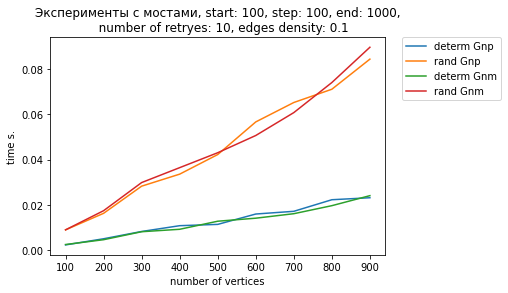

Total time: 13.788602352142334


In [30]:
print(f"Total time: {check_time(plot_bridges, lambda n: 10*n, 100, 100, 1000)}")

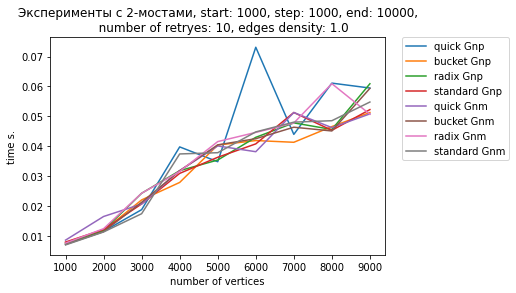

Total time: 31.373921871185303


In [31]:
print(f"Total time: {check_time(plot_2bridges, lambda n: n, 1000, 1000, 10000, 10)}")

In [32]:
def plot_sort(start, end, number_of_retries):
    sorts = [("bucket sort", bucket_argsort), 
             ("radix sort", radix_argsort), 
             ("quick sort", quick_argsort)]
    times = {"bucket sort": [],
             "radix sort": [],
             "quick sort": []}
    x = []
    
    for size in np.logspace(start, end, num=end-start-1, dtype=np.uint64, base=2):
        for name, sort in sorts:
            time = 0.
            for _ in range(number_of_retries):
                array = np.random.randint(0, 0xFFFFFFFFFFFFFFFF, dtype=np.uint64, size=size)
                time +=check_time(sort, array)
            time /= number_of_retries
            times[name].append(time)
        x.append(size)
        
    for name, time in times.items():
        plt.plot(x, time, label = name)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlabel('number of elements')
    plt.ylabel('time s.')
    plt.title(f"Время работы сортировок")
    plt.show()

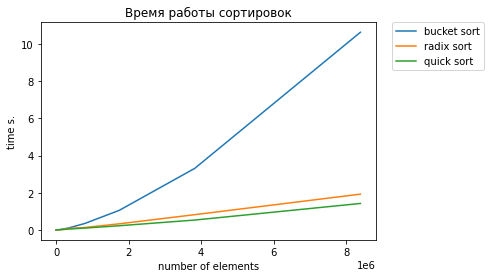

Total time: 215.39870381355286


In [33]:
print(f"Total time: {check_time(plot_sort, 6, 23, 10)}")